# Twitter API Introduction

In this tutorial, we will be praciticing querying the Twitter API in python.

We'll also be using Tweepy - which is a python wrapper that allows us to use the Twitter API. Of course, the Twitter API can be accessed directly as well, but Tweepy has a few extras that makes getting Tweets just a bit easier. 


### Resources and Links

http://docs.tweepy.org/en/latest/


In [1]:
import json
import networkx as nx
import tweepy
# conda install -c conda-forge tweepy
import numpy as np
import matplotlib.pyplot as plt

### Getting New Tweets

Before you can access the API, you'll need to create a developer account and create/register your application wtih Twitter to get the necessary authentication keys. 

https://developer.twitter.com/

In [2]:
info = {"api_key": "",
        "api_key_secret": "",
        "bearer_token" : "",
        "access_token": "",
        "access_token_secret": ""}

My app: https://developer.twitter.com/en/portal/projects/1481027098718334976/apps

In [3]:
info = json.loads(open('../.secrets/twitter_api.json').read())

In [4]:
# Authenticate using our credentials

client = tweepy.Client(
    consumer_key       = info["api_key"],
    consumer_secret    = info["api_key_secret"],
    bearer_token       = info["bearer_token"],
    access_token       = info["access_token"],
    access_token_secret= info["access_token_secret"],
    wait_on_rate_limit = True
)

`search_all_tweets` - academic research mode only  
https://developer.twitter.com/en/products/twitter-api/academic-research  
https://developer.twitter.com/en/docs/twitter-api/tweets/search/introduction  
https://docs.tweepy.org/en/stable/client.html#search-tweets  

In [5]:
covid_tweets = client.search_recent_tweets(
    query="covid-19",
    max_results=100,
)

In [7]:
len(covid_tweets[0])

100

In [9]:
type(covid_tweets)

tweepy.client.Response

In [10]:
for tweet in covid_tweets[0]:
    print(type(tweet))
    print(tweet.data)
    break

<class 'tweepy.tweet.Tweet'>
{'id': '1496260125631336455', 'text': 'RT @olddrummer52: @DeborahMeaden Can I ask how you protected those more vulnerable than you before Covid?\nI’ve a compromised immune system,…'}


In [11]:
len(covid_tweets),covid_tweets[1], covid_tweets[2]

(4, {}, [])

In [8]:
covid_tweets[3]

{'newest_id': '1496260489663373313',
 'oldest_id': '1496260352870428676',
 'result_count': 100,
 'next_token': 'b26v89c19zqg8o3fpe77ew01eq35wboat1snf8lq8h5kt'}

In [11]:
covid_tweets_2 = client.search_recent_tweets(
    query="covid-19",
    max_results=10,
    next_token='b26v89c19zqg8o3fpe77ew01eq35wboat1snf8lq8h5kt'
)

In [12]:
len(covid_tweets_2[0])

10

https://developer.twitter.com/en/docs/twitter-api/fields

In [16]:
fields = "created_at,public_metrics"

In [17]:
covid_tweets_field = client.search_recent_tweets(
    query="covid",
    max_results=10,
    tweet_fields=fields
)

In [18]:
for tweet in covid_tweets_field[0]:
    print(tweet.data)
    print(tweet['created_at'])
    break

{'text': '@MLLACOUTURE Nada y van a las clínicas y no las hacen, mi hermano trató de hacerlo y le colocaron todas las trabas por "el covid"', 'id': '1496261087011954688', 'public_metrics': {'retweet_count': 0, 'reply_count': 0, 'like_count': 0, 'quote_count': 0}, 'created_at': '2022-02-22T23:10:16.000Z'}
2022-02-22 23:10:16+00:00


### Formulating a new query + saving data

https://developer.twitter.com/en/docs/tutorials/building-high-quality-filters

In [19]:
expansions = "author_id,referenced_tweets.id.author_id"

In [20]:
tweets_field_exp = client.search_recent_tweets(
    query="#StopAsianHate",
    max_results=10,
    tweet_fields=fields,
    expansions=expansions
)

In [21]:
### Saving data to your machine
tweet_data_list = [tweet.data for tweet in tweets_field_exp[0]]
with open("query1.json", "w") as outfile:
    json.dump(tweet_data_list, outfile, indent=4)


### Getting re-tweeters

https://docs.tweepy.org/en/stable/client.html#tweet-lookup

In [5]:
tweet_data_list = json.loads(open('./query1.json').read())

In [6]:
retweeters = []
# Go through the tweet data list
for tweet_dict in tweet_data_list:
    # Get the referenced tweets
    ref_tweet = tweet_dict.get('referenced_tweets')
    # If there is one, get the first one and see if it's a retweet or quote tweet
    if ref_tweet and ref_tweet[0]['type'] in ['retweeted','quoted']:
        # Get that referenced tweet
        ref_tweet = client.get_tweet(
            id=ref_tweet[0]['id'],
            expansions='author_id'
        )
        # add the original and the referenced to the list
        retweeters.append(
            [ tweet_dict.get('author_id'), ref_tweet[0].data.get('author_id')]
        )em

In [7]:
retweeters

[['1448776993776889871', '249862904'],
 ['1487172027995889664', '1484294034038394881'],
 ['262764749', '1493404058'],
 ['456017662', '1018524702757793792'],
 ['1373736443219152903', '1488913117'],
 ['1373736443219152903', '1488913117'],
 ['1653965882', '1477133875717591042']]

In [18]:
connections = np.array(retweeters).flatten()

nodes = list(set(connections))

len(connections), len(nodes)

(14, 12)

In [19]:
TW_G = nx.DiGraph()
TW_G.add_nodes_from(nodes)
TW_G.add_edges_from(retweeters)

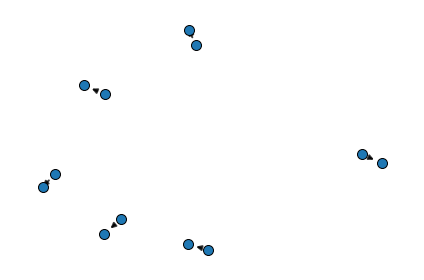

In [21]:
ax = plt.subplots()

pos = nx.spring_layout(TW_G, seed=170)
nx.draw_networkx_edges(TW_G, pos, alpha=0.75, width=2)
nx.draw_networkx_nodes(TW_G, pos, node_size=100).set_edgecolor('black')

plt.tight_layout()
plt.axis("off")
plt.show()